# Readmission Risk Model — Logistic Regression

This notebook trains and evaluates a **logistic regression** model to predict hospital readmission using the synthetic dataset in `../data/hospital_data.csv`.

It is designed to be clean, readable, and production-ready, with clear structure and Google-style docstrings for helper functions.

In [12]:
from __future__ import annotations

import os
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder



In [13]:
DATA_PATH = "../data/hospital_data.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,Patient_ID,Age,Gender,Diagnosis,Treatment,Length_of_Stay,Outcome,Readmission
0,P0001,45,F,Heart Failure,Medication,5,Recovered,No
1,P0002,60,M,Pneumonia,Antibiotics,7,Recovered,No
2,P0003,30,F,Diabetes,Insulin,3,Recovered,Yes
3,P0004,77,M,Stroke,Surgery,10,Recovered,No
4,P0005,50,F,Diabetes,Insulin,4,Recovered,Yes


In [14]:
def split_features_target(
    data: pd.DataFrame, target_col: str = "Readmission"
) -> Tuple[pd.DataFrame, pd.Series]:
    """Split a DataFrame into features and target.

    Args:
        data: Full input DataFrame containing features and target.
        target_col: Name of the target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]:
        A tuple of (X, y) where X contains all feature columns and y is the target.
    """
    if target_col not in data.columns:
        raise KeyError(f"Target column '{target_col}' not found in DataFrame.")

    X = data.drop(columns=[target_col])
    y = data[target_col]
    return X, y

X, y = split_features_target(df, target_col="Readmission")
X.head()

,Patient_ID,Age,Gender,Diagnosis,Treatment,Length_of_Stay,Outcome
0,P0001,45,F,Heart Failure,Medication,5,Recovered
1,P0002,60,M,Pneumonia,Antibiotics,7,Recovered
2,P0003,30,F,Diabetes,Insulin,3,Recovered
3,P0004,77,M,Stroke,Surgery,10,Recovered
4,P0005,50,F,Diabetes,Insulin,4,Recovered


In [15]:
# Identify column types
categorical_cols: List[str] = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols: List[str] = X.select_dtypes(include=["number"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Column transformer for preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape

Categorical columns: ['Patient_ID', 'Gender', 'Diagnosis', 'Treatment', 'Outcome']
Numeric columns: ['Age', 'Length_of_Stay']


((16, 7), (4, 7))

In [16]:
log_reg_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "clf",
            LogisticRegression(
                max_iter=500,
                n_jobs=-1,
                class_weight='balanced'
            ),
        ),
    ]
)

log_reg_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Patient_ID', 'Gender',
                                                   'Diagnosis', 'Treatment',
                                                   'Outcome']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'Length_of_Stay'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    n_jobs=-1))])

In [17]:
def evaluate_classifier(
    name: str,
    model: Pipeline,
    X_test: pd.DataFrame,
    y_test: pd.Series,
) -> Dict[str, float]:
    """Evaluate a classifier on test data and print key metrics.

    Args:
        name: Human-readable model name.
        model: Fitted sklearn Pipeline.
        X_test: Test features.
        y_test: Ground-truth labels.

    Returns:
        Dict[str, float]: accuracy, precision, recall, F1, ROC-AUC.
    """
    y_pred = model.predict(X_test)

    # Try probability for ROC-AUC
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except Exception:
        roc_auc = float("nan")

    # Explicitly set the positive label
    pos = sorted(y_test.unique())[-1]   # positive = lexicographically last

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=pos, zero_division=0)
    rec = recall_score(y_test, y_pred, pos_label=pos, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=pos, zero_division=0)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
    }

    print(f"{name} performance:")
    for k, v in metrics.items():
        print(f"  {k:9s}: {v:.3f}")

    return metrics

log_metrics = evaluate_classifier("Logistic Regression", log_reg_model, X_test, y_test)
log_metrics

Logistic Regression performance:
  accuracy : 0.500
  precision: 0.000
  recall   : 0.000
  f1       : 0.000
  roc_auc  : 0.500


{'accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc_auc': 0.5}

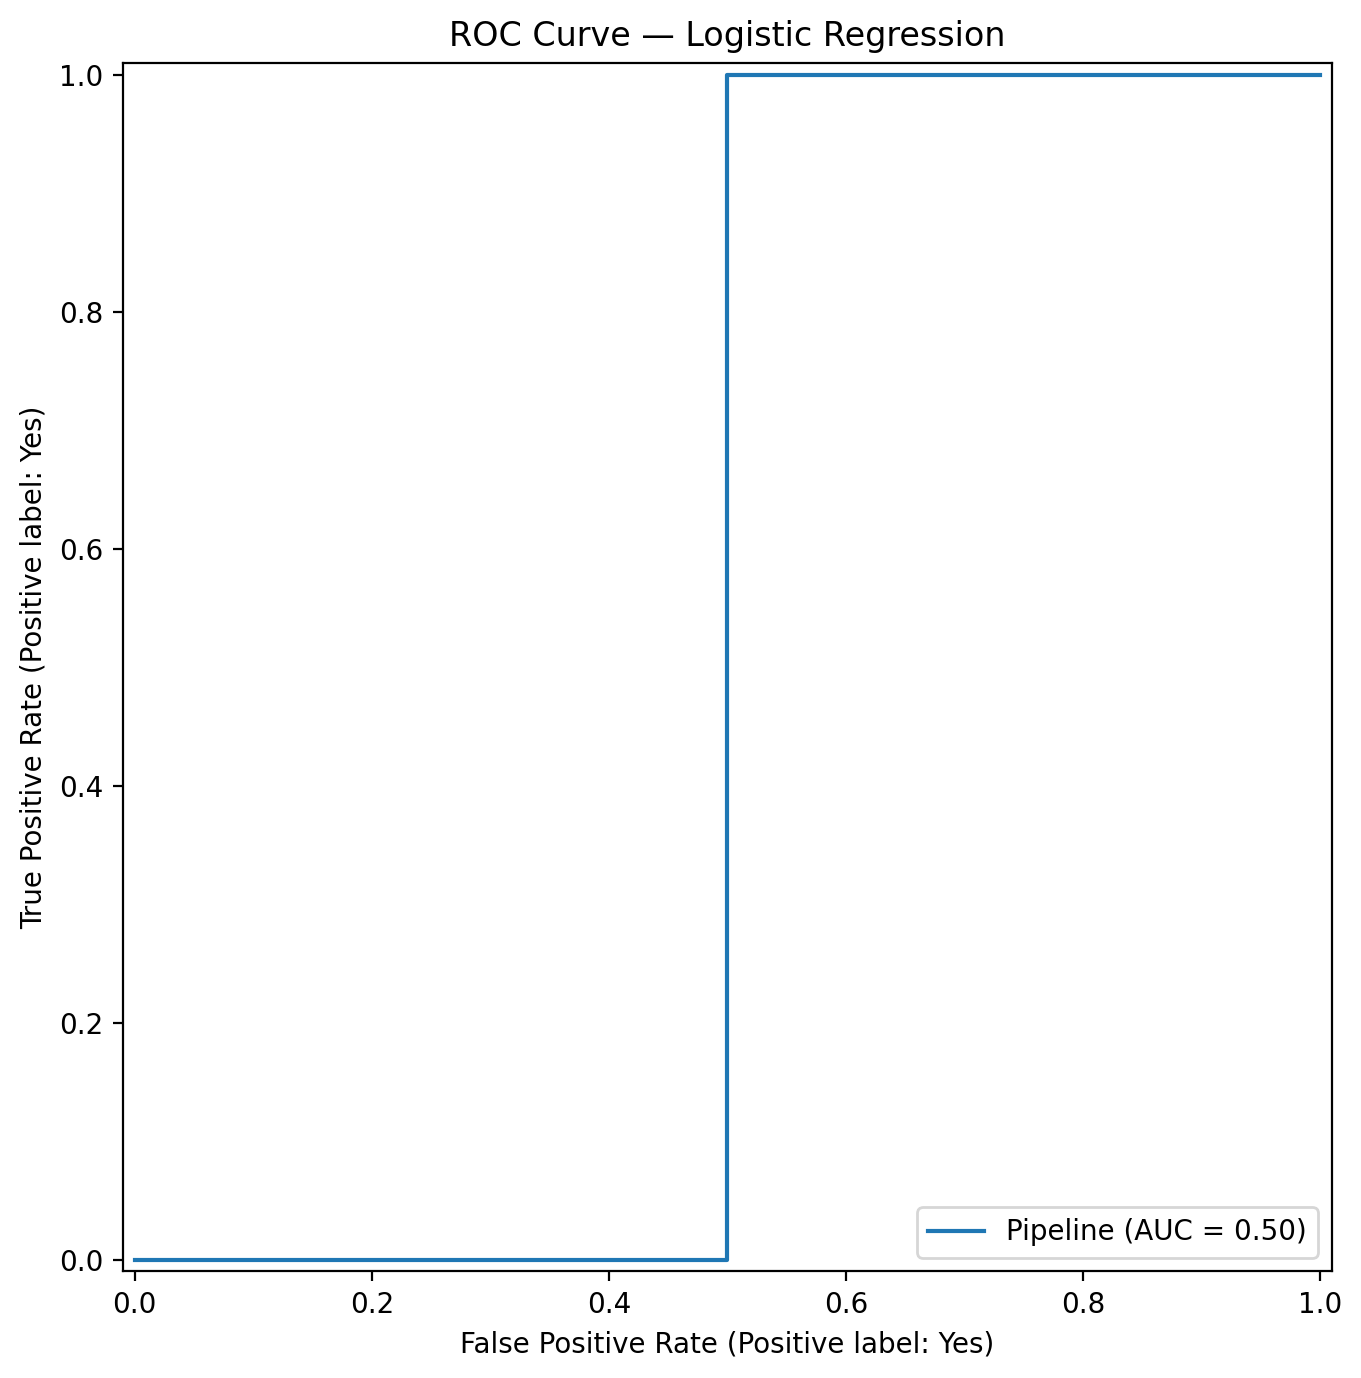

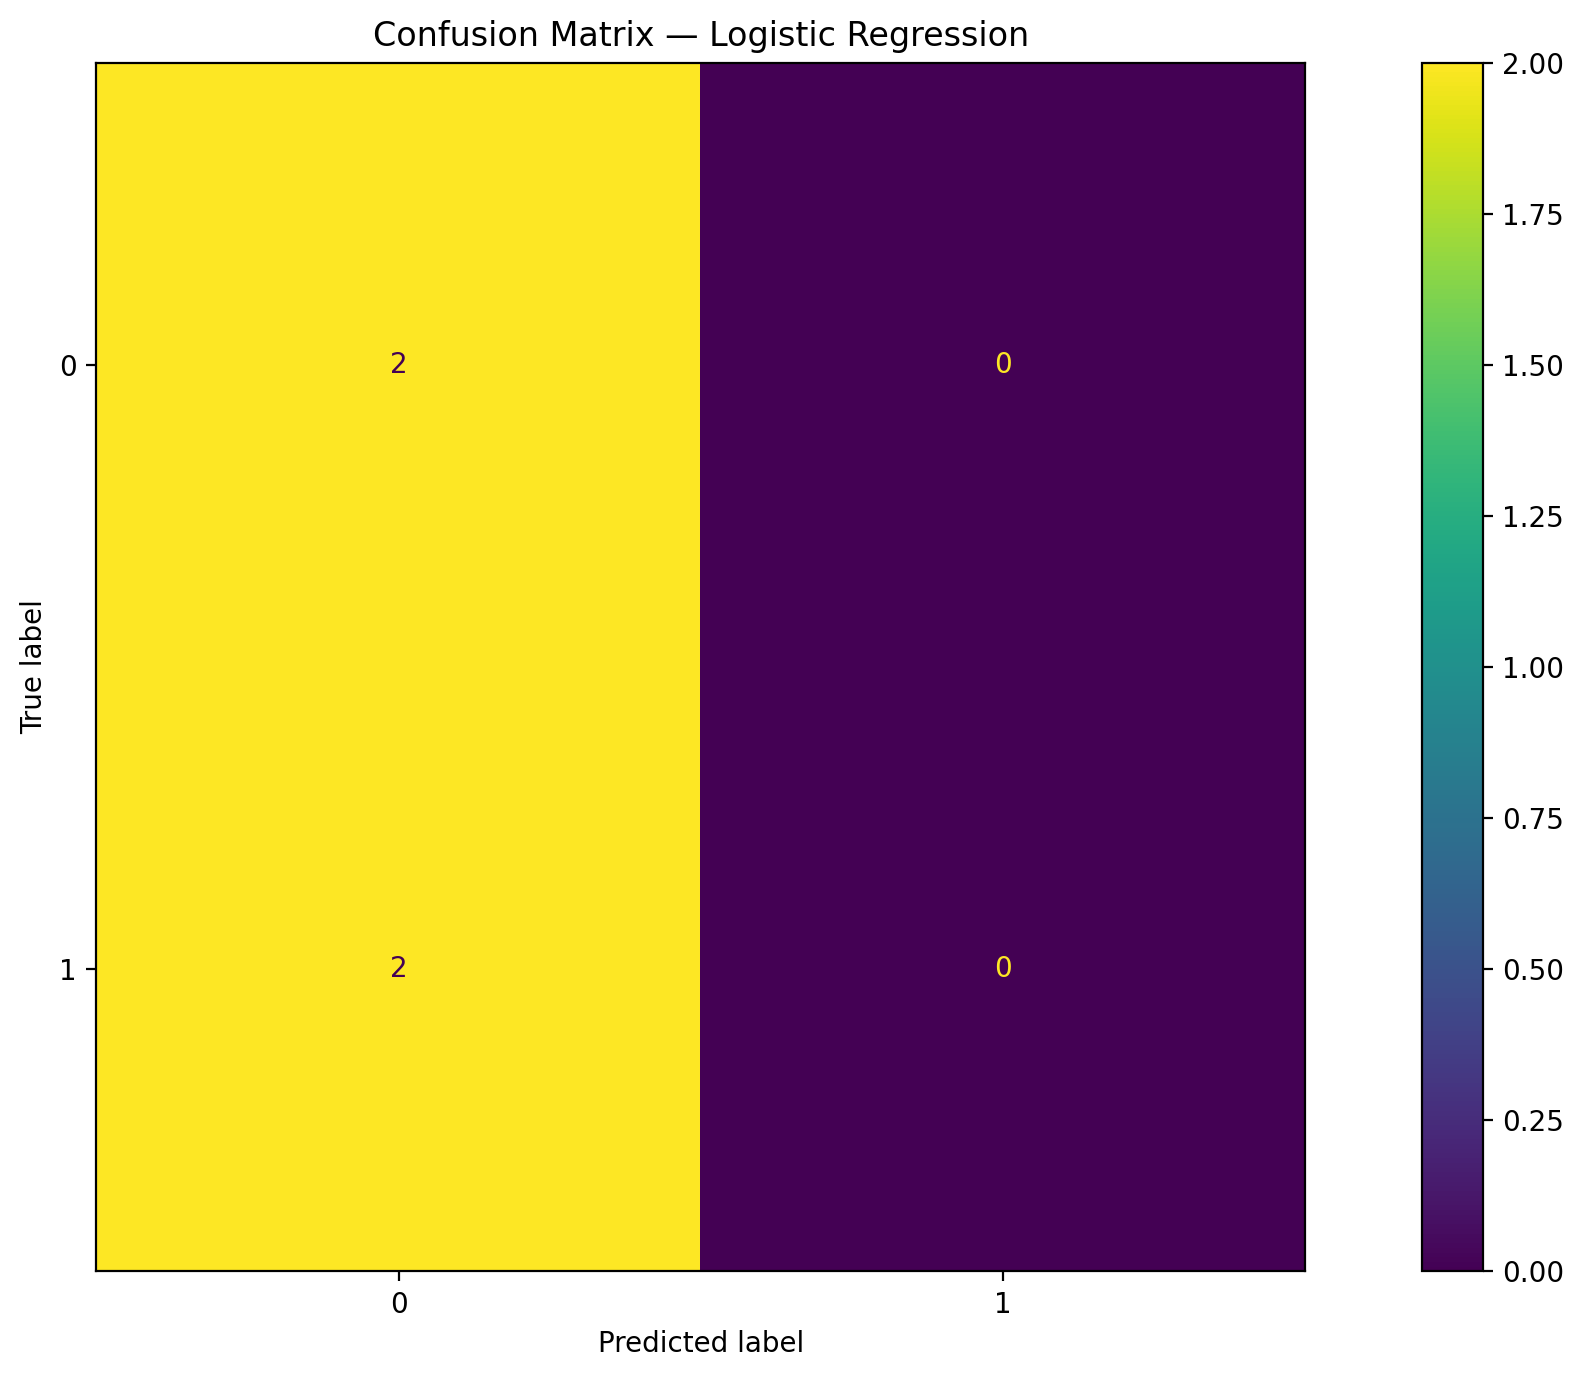

In [18]:
# ROC curve
RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test)
plt.title("ROC Curve — Logistic Regression")
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, log_reg_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.show()

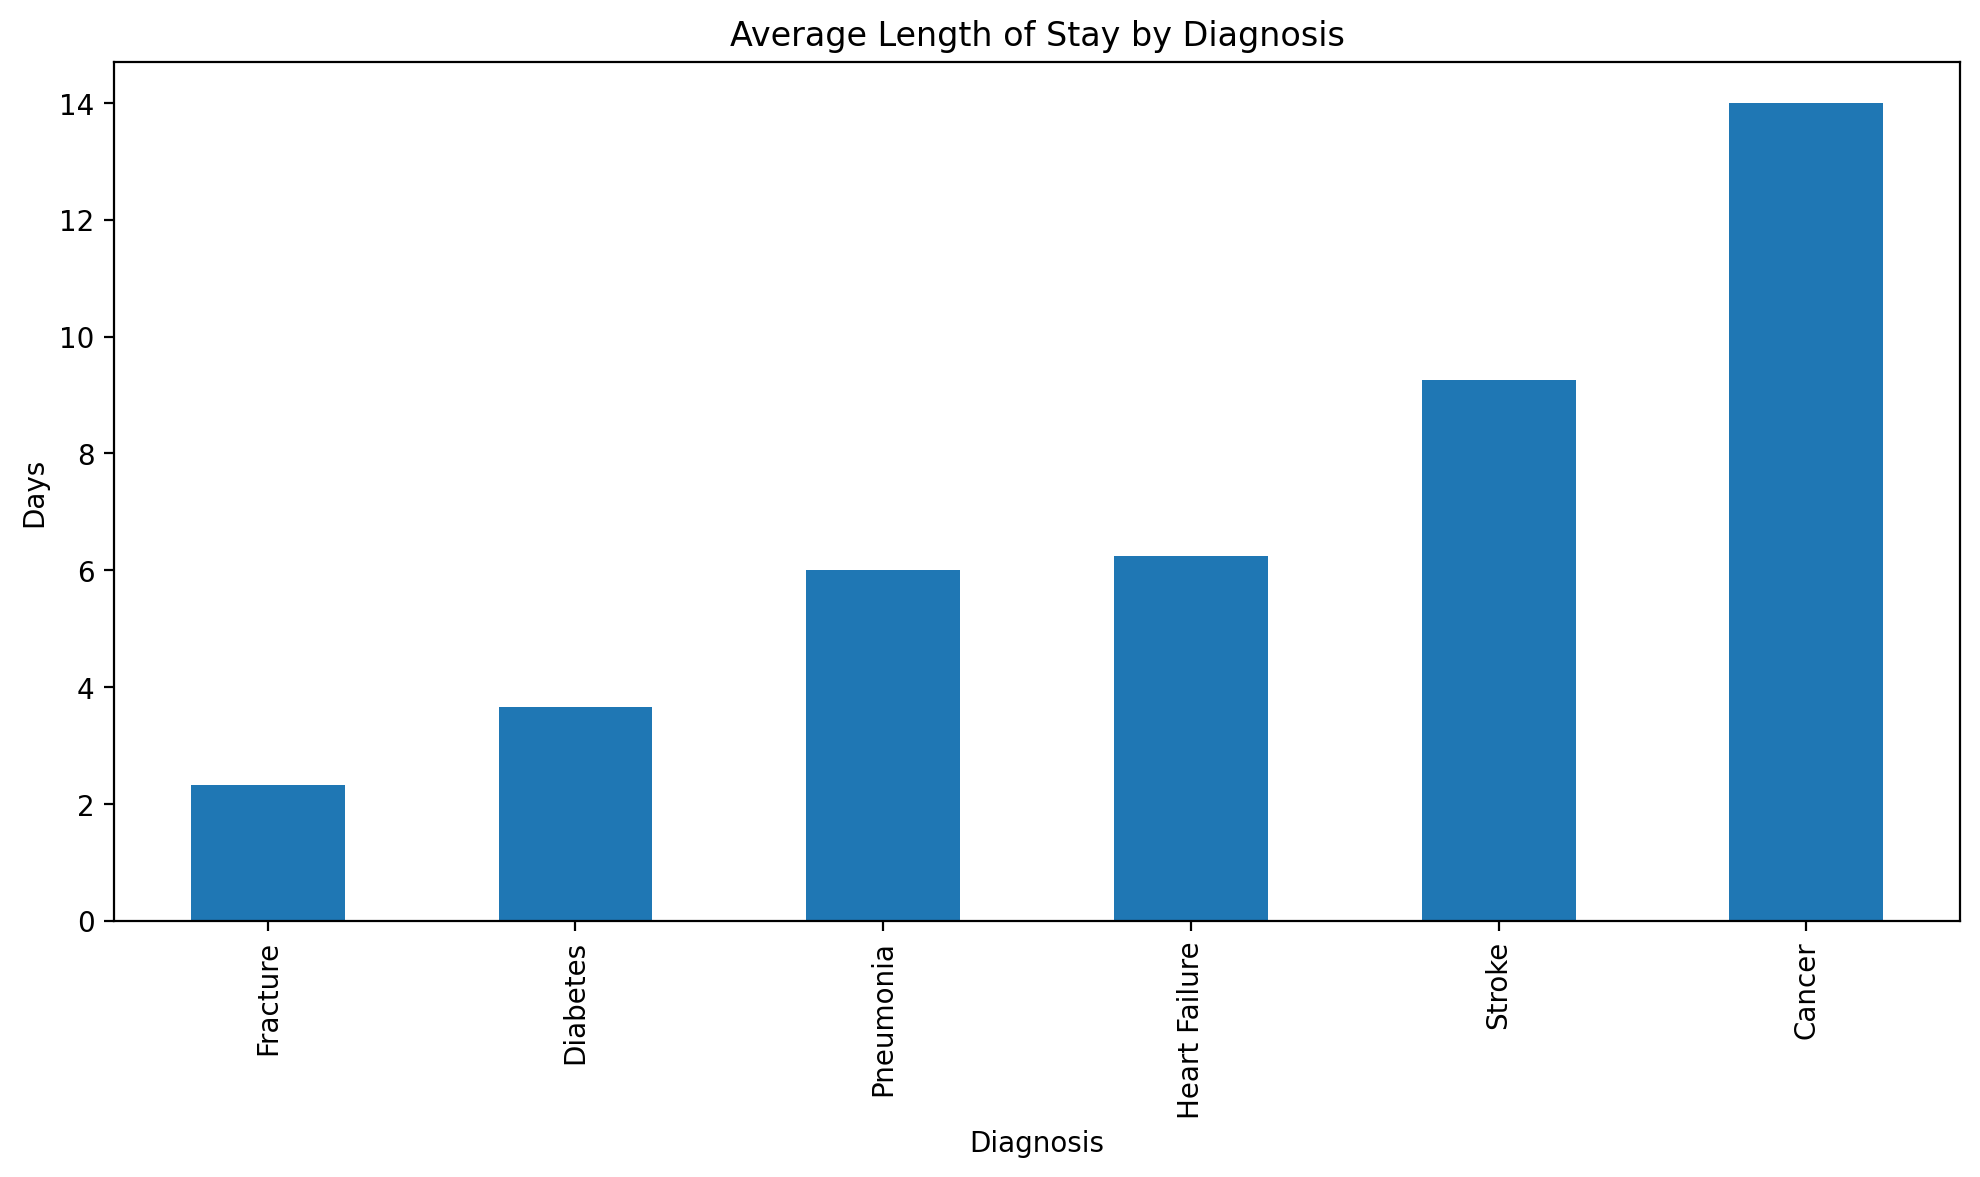

/tmp/ipykernel_370/2667848829.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readm_by_age = df.groupby("Age_Group")["ReadmissionNumeric"].mean()


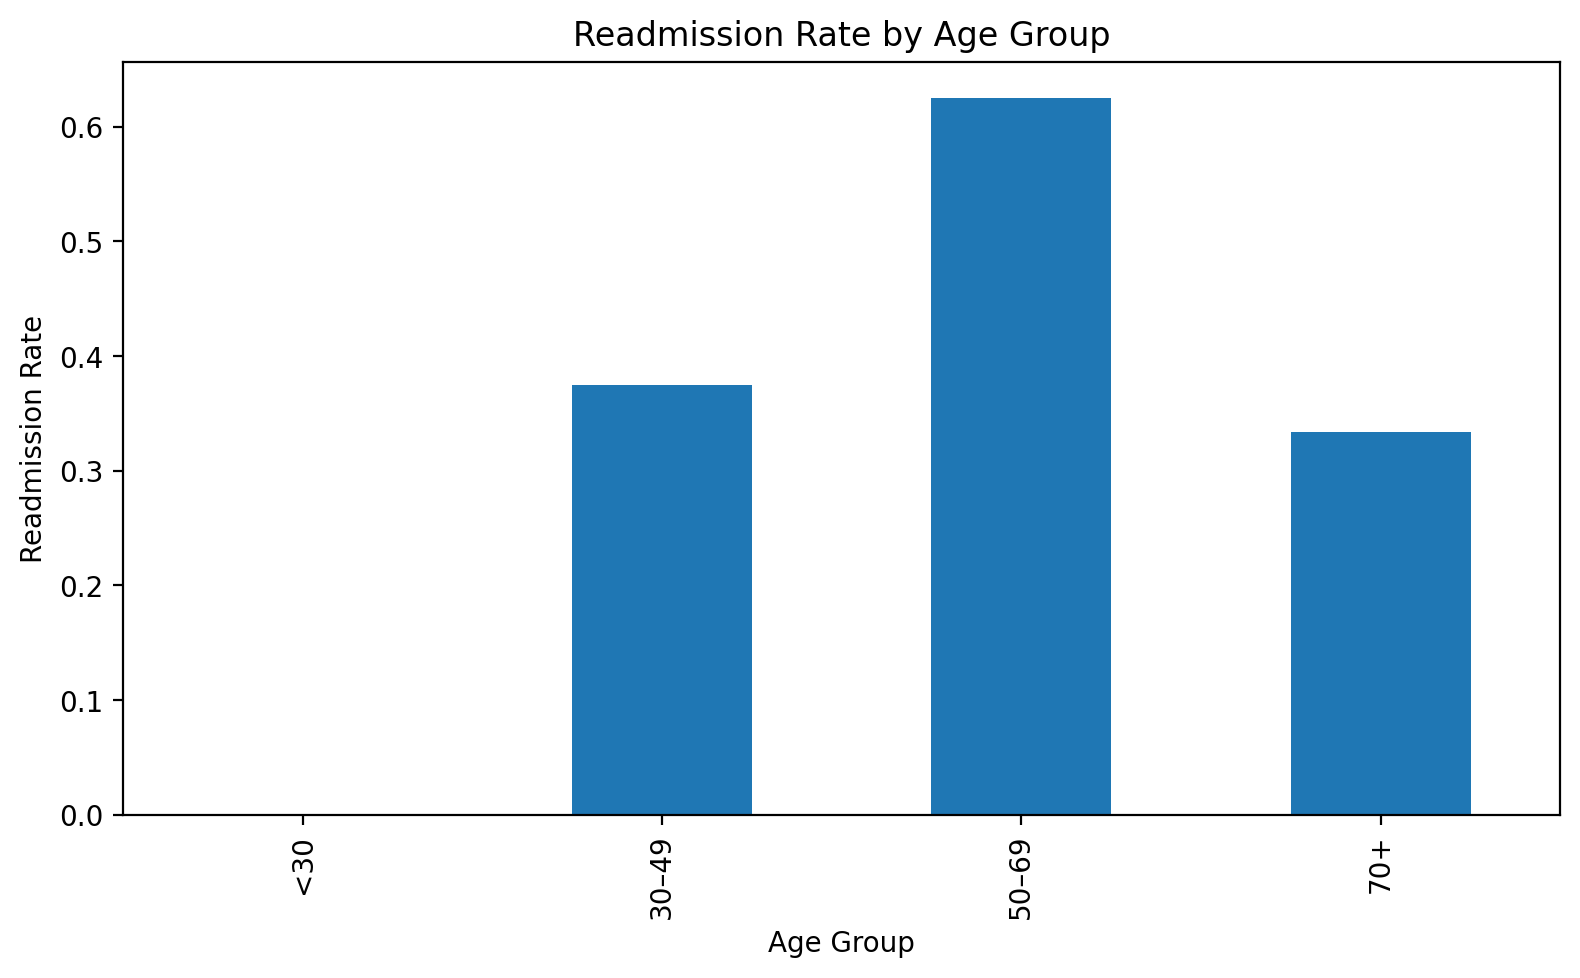

In [19]:
# Create assets directory for saving figures
os.makedirs("assets", exist_ok=True)

# 1) Average Length of Stay by Diagnosis
los_by_dx = df.groupby("Diagnosis")["Length_of_Stay"].mean().sort_values()

plt.figure(figsize=(10, 6))
los_by_dx.plot(kind="bar")
plt.title("Average Length of Stay by Diagnosis")
plt.ylabel("Days")
plt.xlabel("Diagnosis")
plt.tight_layout()
plt.savefig("assets/los_by_diagnosis.png", dpi=150)
plt.show()

# 2) Readmission rate by age group
age_bins = [0, 30, 50, 70, 100]
age_labels = ["<30", "30–49", "50–69", "70+"]

df["Age_Group"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=False)
df["ReadmissionNumeric"] = (df["Readmission"] == "Yes").astype(int)
readm_by_age = df.groupby("Age_Group")["ReadmissionNumeric"].mean()

plt.figure(figsize=(8, 5))
readm_by_age.plot(kind="bar")
plt.title("Readmission Rate by Age Group")
plt.ylabel("Readmission Rate")
plt.xlabel("Age Group")
plt.tight_layout()
plt.savefig("assets/readmission_by_age.png", dpi=150)
plt.show()